In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [4]:
main_dir = '/tf/notebooks/'

In [5]:
probs_path = main_dir+'final-project/Classification/data/party'

In [6]:
val_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'val_pred_probs_mlp_ngram.npy'))
val_pred_probs_cnn = np.load(os.path.join(probs_path, 'val_pred_probs_cnn.npy'))
val_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'val_pred_probs_cnn_aggr_chunk.npy'))

In [7]:
len(val_pred_probs_mlp_ngram), len(val_pred_probs_cnn), len(val_pred_probs_cnn_aggr_chunk)

(101153, 101153, 101153)

In [8]:
with open(os.path.join(probs_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(probs_path, 'val_list'), 'rb') as fp:
    val_list = pickle.load(fp)

In [9]:
len(val_ids), len(val_target), len(val_list)

(101153, 101153, 101153)

In [10]:
val_preds_mlp_ngram = val_pred_probs_mlp_ngram > 0.5
val_preds_cnn = val_pred_probs_cnn > 0.5
val_preds_cnn_aggr_chunk = val_pred_probs_cnn_aggr_chunk > 0.5

In [11]:
sum(val_preds_mlp_ngram), sum(val_preds_cnn), sum(val_preds_cnn_aggr_chunk)

(array([54793]), array([56555]), 56545)

In [12]:
classes = ['Republican', 'Democrat']

Confusion matrix, without normalization
[[31089 16240]
 [15271 38553]]
              precision    recall  f1-score   support

  Republican       0.67      0.66      0.66     47329
    Democrat       0.70      0.72      0.71     53824

   micro avg       0.69      0.69      0.69    101153
   macro avg       0.69      0.69      0.69    101153
weighted avg       0.69      0.69      0.69    101153



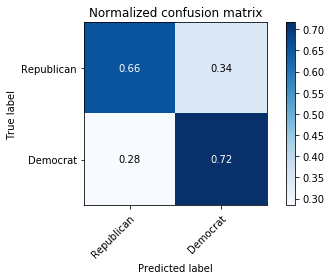

In [13]:
explore_data.plot_confusion_matrix(val_target, val_preds_mlp_ngram, classes, normalize=True)

Confusion matrix, without normalization
[[28560 18769]
 [16038 37786]]
              precision    recall  f1-score   support

  Republican       0.64      0.60      0.62     47329
    Democrat       0.67      0.70      0.68     53824

   micro avg       0.66      0.66      0.66    101153
   macro avg       0.65      0.65      0.65    101153
weighted avg       0.66      0.66      0.66    101153



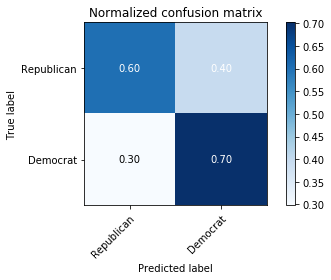

In [14]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn, classes, normalize=True)

Confusion matrix, without normalization
[[29534 17795]
 [15074 38750]]
              precision    recall  f1-score   support

  Republican       0.66      0.62      0.64     47329
    Democrat       0.69      0.72      0.70     53824

   micro avg       0.68      0.68      0.68    101153
   macro avg       0.67      0.67      0.67    101153
weighted avg       0.67      0.68      0.67    101153



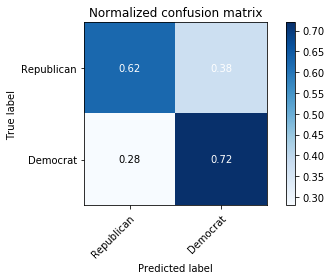

In [15]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn_aggr_chunk, classes, normalize=True)

In [33]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.reset_index(inplace=True)
# descr_df.drop_duplicates('speech_id', inplace=True)
descr_df.shape

(106095, 17)

In [72]:
descr_df[descr_df['Full Name']=='HASTINGS, ALCEE'].Party.value_counts()

D    175
Name: Party, dtype: int64

In [74]:
descr_df[descr_df['Full Name']=='HASTINGS, ALCEE'].head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
702,1120025509,20110502,1275,222,112119720.0,D,112,H,FL,B,76.0,0.0,1.0,0.0,Mr. HASTINGS of Florida,"HASTINGS, ALCEE",fuzzy
1162,1090180057,20060929,3282,555,109119720.0,D,109,H,FL,B,70.0,0.0,1.0,0.0,Mr. HASTINGS of Florida,"HASTINGS, ALCEE",exact
1543,1070166436,20020926,192,36,107119720.0,D,107,H,FL,B,66.0,0.0,1.0,0.0,Mr. HASTINGS of Florida,"HASTINGS, ALCEE",exact
2101,1140045958,20150728,1755,294,114119720.0,D,114,H,FL,B,80.0,0.0,1.0,0.0,MR. HASTINGS,"HASTINGS, ALCEE",exact
2108,1120093362,20120321,774,152,112119720.0,D,112,H,FL,B,76.0,0.0,1.0,0.0,Mr. HASTINGS of Florida,"HASTINGS, ALCEE",exact


In [36]:
descr_df[descr_df.duplicated('speech_id')].shape

(4942, 17)

In [37]:
descr_df[descr_df.duplicated(['speech_id','Party'])].shape

(3313, 17)

In [38]:
pred_df = pd.DataFrame({'ids': np.asarray(val_ids, dtype=np.int64), 
                        'Party_model': np.asarray(val_target, dtype=np.int), 
                        'pred_probs_mlp_ngram': val_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': val_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': val_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(101153, 5)

In [82]:
check_ids = np.asarray(val_ids, dtype=np.int64)
check_target = np.asarray(val_target, dtype=np.int)
check_d = descr_df[descr_df['Full Name']=='HASTINGS, ALCEE'].speech_id.values

In [87]:
descr_df[descr_df.speech_id==1110014306]

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
57977,1110014306,20090213,1983,337,111119720.0,D,111,H,FL,B,74.0,0.0,1.0,0.0,Mr.. HASTINGS of Florida,"HASTINGS, ALCEE",fuzzy
57978,1110014306,20090213,1983,337,111117640.0,R,111,H,WA,W,69.0,0.0,0.0,0.0,Mr.. HASTINGS of Florida,"HASTINGS, DOC",fuzzy


In [85]:
for i in range(len(check_d)):
    if check_target[val_ids.index(str(check_d[i]))] == 0:
        print(check_d[i])

1110014306
1120096995
1070060138
1110091559
1130115420
1070003247
1050047810
1040189154
1070166337
1100016253
1110071223
1080007397
1050036410
1100180758
1100090299
1110127592
1120006336
1130001848
1100088930
1070035488
1070155382
1120107729
1120061743
1120046469
1090053078
1120030048
1120112149
1090024384
1120080299
1100158799
1130116706
1080123377
1110132392
1090043213
1130022822


In [80]:
pred_df.ids.nunique()

101153

In [39]:
pred_df.Party_model.value_counts()

1    53824
0    47329
Name: Party_model, dtype: int64

In [88]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(106095, 22)

In [89]:
descr_pred_df[descr_pred_df.duplicated(['speech_id','Party_model'])].shape

(4942, 22)

In [105]:
descr_pred_df.drop_duplicates(['speech_id'], inplace=True)
descr_pred_df.reset_index(inplace=True)
descr_pred_df.shape

(101153, 25)

In [106]:
descr_pred_df.Party_model.value_counts()

1    53824
0    47329
Name: Party_model, dtype: int64

In [107]:
pd.crosstab(descr_pred_df.Party, descr_pred_df.Party_model)

Party_model,0,1
Party,,
D,421,53467
I,4,1
R,46904,356


In [108]:
descr_pred_df[descr_pred_df['Full Name']=='HASTINGS, ALCEE'].Party_model.value_counts()

1    132
0     30
Name: Party_model, dtype: int64

In [110]:
descr_pred_df.shape

(101153, 25)

In [112]:
party_dummy = []
for p in range(descr_pred_df.shape[0]):
    if descr_pred_df.Party[p] == 'D':
        party_dummy.append(1)
    else:
        party_dummy.append(0)
len(party_dummy)
descr_pred_df['Party_dummy'] = party_dummy

In [95]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [113]:
descr_pred_df[preds+['Party']].groupby('Party').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Party,,,
D,0.641810,0.615958,0.560174
I,0.535552,0.491995,0.532681
R,0.394023,0.426366,0.463500


In [114]:
descr_pred_df[preds+['Party_dummy']].groupby('Party_dummy').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Party_dummy,,,
0,0.394038,0.426373,0.463507
1,0.641810,0.615958,0.560174


In [115]:
preds_combo = []
for i in range(1, len(preds)+1):
    preds_combo.extend(list(itertools.combinations(preds, i)))
len(preds_combo)

7

In [116]:
preds_combo_results = []
for i in range(len(preds_combo)):
    temp = descr_pred_df[list(preds_combo[i])]
    avg = temp.mean(axis=1)
    avg_pred = avg > 0.5
    result = np.mean(avg_pred==descr_pred_df['Party_dummy'])
    preds_combo_results.append((preds_combo[i], result))

In [117]:
preds_combo_results = sorted(preds_combo_results, key=lambda x: -x[1])
preds_combo_results

[(('pred_probs_mlp_ngram', 'pred_probs_cnn_chunk'), 0.698773145630876),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn', 'pred_probs_cnn_chunk'),
  0.6981305547042599),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn'), 0.6935335580753907),
 (('pred_probs_mlp_ngram',), 0.6886004369618302),
 (('pred_probs_cnn_chunk',), 0.6752740897452374),
 (('pred_probs_cnn', 'pred_probs_cnn_chunk'), 0.6712109378861725),
 (('pred_probs_cnn',), 0.6560161339752651)]

In [119]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[list(preds_combo_results[0][0])].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(val_target==descr_pred_df['pred_combo'].values.flatten())

0.6987929176593872

### Save the main dataframe

In [136]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [137]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'party_preds.pkl'))

### Evaluating final predictions

Confusion matrix, without normalization
[[31362 15967]
 [14501 39323]]
              precision    recall  f1-score   support

  Republican       0.68      0.66      0.67     47329
    Democrat       0.71      0.73      0.72     53824

   micro avg       0.70      0.70      0.70    101153
   macro avg       0.70      0.70      0.70    101153
weighted avg       0.70      0.70      0.70    101153



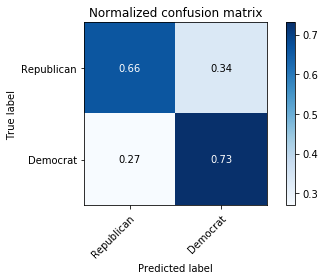

In [120]:
explore_data.plot_confusion_matrix(val_target, descr_pred_df['pred_combo'], classes, normalize=True)

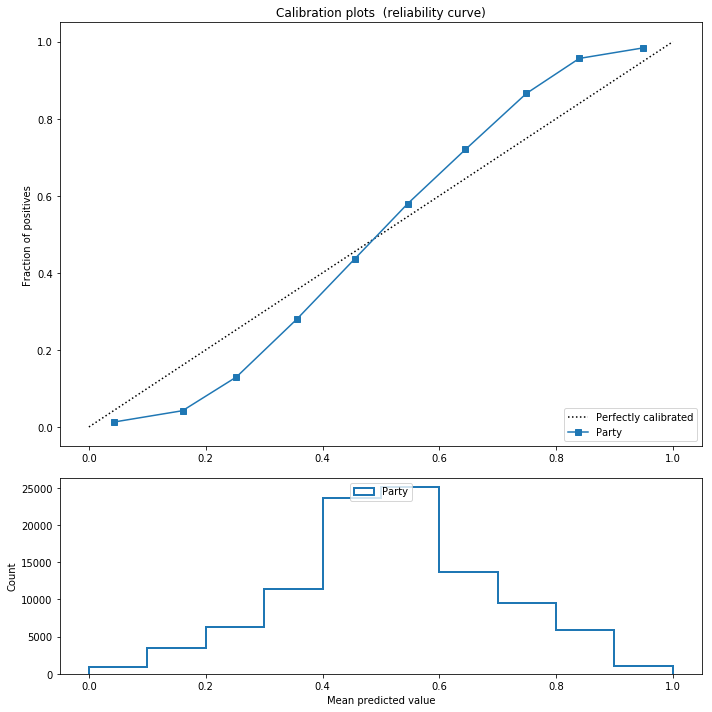

In [121]:
explore_data.plot_calibration_curve(val_target, descr_pred_df['pred_probs_combo'], 'Party')

In [122]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   val_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.091673       0.098836  57.724436  0.529214     0.6059    381.480277


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.61,0.47,0.99,0.36,0.97,1.11
0.6,0.77,0.79,1.00,0.96,0.97,0.82
1.0,1.65,1.73,1.01,1.53,1.08,1.21


In [138]:
reload(explore_data)
explore_data.compare_ngrams(val_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,spending,9397.0,3989.0,4365.0,876.0
1,republican,2541.0,2471.0,7853.0,753.0
2,families,3728.0,4381.0,9850.0,736.0
3,taxes,5508.0,2265.0,2451.0,570.0
4,spend,3184.0,1878.0,2005.0,505.0
5,lives,2275.0,3808.0,5542.0,503.0
6,republicans,2042.0,1319.0,4509.0,492.0
7,women,2594.0,4854.0,9824.0,484.0
8,education,4099.0,6195.0,11872.0,484.0
9,democrat,1310.0,460.0,542.0,422.0


## Congressperson level analysis

In [124]:
speaker_df = descr_pred_df[['Full Name', 'Party_dummy', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo']]\
                .groupby(['Full Name', 'Party_dummy', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean', 'count'], 'Age': ['mean']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['Party_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1778, 9)

Confusion matrix, without normalization
[[738 160]
 [ 65 815]]
              precision    recall  f1-score   support

  Republican       0.92      0.82      0.87       898
    Democrat       0.84      0.93      0.88       880

   micro avg       0.87      0.87      0.87      1778
   macro avg       0.88      0.87      0.87      1778
weighted avg       0.88      0.87      0.87      1778



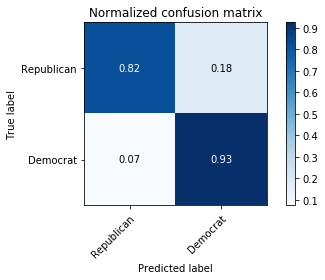

In [125]:
explore_data.plot_confusion_matrix(speaker_df.Party_dummy_, speaker_df.Party_pred_, classes, normalize=True)

In [126]:
speaker_df.pred_probs_combo_count.median()

25.0

In [127]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(874, 9)

Confusion matrix, without normalization
[[364  51]
 [  8 451]]
              precision    recall  f1-score   support

  Republican       0.98      0.88      0.93       415
    Democrat       0.90      0.98      0.94       459

   micro avg       0.93      0.93      0.93       874
   macro avg       0.94      0.93      0.93       874
weighted avg       0.94      0.93      0.93       874



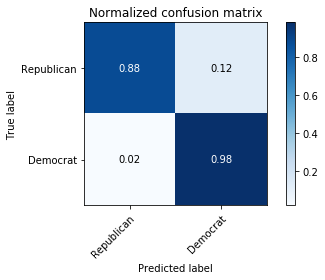

In [128]:
explore_data.plot_confusion_matrix(speaker_med_df.Party_dummy_, speaker_med_df.Party_pred_, classes, normalize=True)

In [129]:
tp = np.argmax(speaker_med_df[speaker_med_df.Party_dummy_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==1].iloc[tp]

Full Name_                PERLMUTTER, ED
Party_dummy_                           1
State_                                CO
Female_                                0
NonWhite_                              0
Age_mean                         59.4242
pred_probs_combo_mean           0.782569
pred_probs_combo_count                99
Party_pred_                         True
Name: 1289, dtype: object

In [130]:
tn = np.argmin(speaker_med_df[speaker_med_df.Party_dummy_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==0].iloc[tn]

Full Name_                GRAVES, SAM
Party_dummy_                        0
State_                             MO
Female_                             0
NonWhite_                           0
Age_mean                      45.2407
pred_probs_combo_mean        0.133414
pred_probs_combo_count            108
Party_pred_                     False
Name: 662, dtype: object

In [131]:
fp = np.argmax(speaker_med_df[speaker_med_df.Party_dummy_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==0].iloc[fp]

Full Name_                MILLER, CLARENCE
Party_dummy_                             0
State_                                  OH
Female_                                  0
NonWhite_                                0
Age_mean                             70.16
pred_probs_combo_mean             0.608429
pred_probs_combo_count                  50
Party_pred_                           True
Name: 1146, dtype: object

In [132]:
fn = np.argmin(speaker_med_df[speaker_med_df.Party_dummy_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.Party_dummy_==1].iloc[fn]

Full Name_                ZORINSKY, EDWARD
Party_dummy_                             1
State_                                  NE
Female_                                  0
NonWhite_                                0
Age_mean                           56.5625
pred_probs_combo_mean             0.439708
pred_probs_combo_count                  32
Party_pred_                          False
Name: 1776, dtype: object

## Congress level analysis

In [134]:
congress_df = descr_pred_df[['Congress', 'Party_dummy', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'Party_dummy': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.Party_dummy_mean
congress_df.shape

(18, 5)

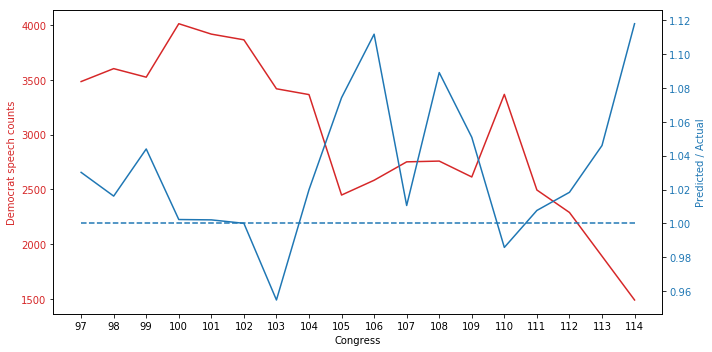

In [135]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Democrat speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.Party_dummy_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()